In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
# load mnist data set containing images of digits
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# The generator network
def generator(z, reuse=None): # z represents random noise used to start the generator
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128)
        
        # leaky rectified linear unit -> not defined in tf 1.3.0.
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        output = tf.layers.dense(hidden2, units=784, activation=tf.nn.tanh) # output will be size of 28x28 image
        
        return output
        

In [6]:
# The discriminator network
def discriminator(X, reuse=None):
    with  tf.variable_scope('dis', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X, units=128)
        
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2, units=1)
        
        output = tf.sigmoid(logits)
        
        return output, logits

In [7]:
real_images = tf.placeholder(tf.float32, shape=[None, 784]) # placeholder for batch of images
z = tf.placeholder(tf.float32, shape=[None, 100])

In [8]:
G = generator(z)

In [9]:
D_output_real, D_logits_real = discriminator(real_images)

In [10]:
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

In [11]:
# loss function
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits_in, labels=labels_in))

In [12]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)

In [18]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [19]:
batch_size = 100

In [40]:
epochs = 500

In [41]:
init = tf.global_variables_initializer()

In [42]:
samples = []

In [47]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784)) # reshape the images into pixels
            batch_images = batch_images * 2 - 1 #  rescale the values for the tanh activation function
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            _ = sess.run(D_trainer, feed_dict={real_images:batch_images, z:batch_z})
            _ = sess.run(G_trainer, feed_dict={z:batch_z})
            
        print("On Epoch {}".format(epoch))
        
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z:sample_z})
        
        samples.append(gen_sample)
        
        
        

On Epoch 0


KeyboardInterrupt: 

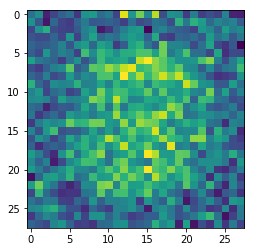

In [57]:
plt.imshow(samples[0].reshape(28, 28))

In [48]:
saver = tf.train.Saver(var_list=g_vars)

In [58]:
# using pre-trained model with 500 epochs
new_samples = []
with tf.Session() as sess:
    saver.restore(sess, './models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        
        gen_sample = sess.run(generator(z, reuse=True), feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./models/500_epoch_model.ckpt


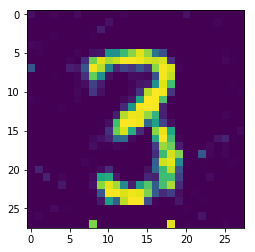

In [64]:
plt.imshow(new_samples[4].reshape(28, 28))